# Build station features and exploratory analysis

This notebook processes minute-level GTFS-realtime snapshots, 
builds station-level features and explores the resulting dataset.

### Re-run data ingestion

In [1]:
# ruff: noqa
from pathlib import Path

import pandas as pd

from metro_disruptions_intelligence.etl.ingest_rt import ingest_all_rt

project_root = Path.cwd()
if not (project_root / "sample_data").exists():
    project_root = project_root.parent

raw_root = project_root / "data" / "raw"
processed_rt = project_root / "data" / "processed_final" / "rt"

In [2]:
print(processed_rt)

c:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\processed_final\rt


In [3]:
ingest_all_rt(raw_root, processed_rt)

### Feature Engineering

In [1]:
import pandas as pd
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pytz

from metro_disruptions_intelligence.features import SnapshotFeatureBuilder, build_route_map

In [2]:
project_root = Path.cwd()
if not (project_root / "notebooks").exists():
    project_root = project_root.parent

processed_rt = project_root / "data" / "processed_final" / "rt"
features_root = project_root / "data" / "stations_features_time_series"
features_root.mkdir(parents=True, exist_ok=True)

In [3]:
processed_rt, features_root

(WindowsPath('c:/Users/Luis.ParraMorales/GitProjects/metro_disruptions_intelligence/data/processed_final/rt'),
 WindowsPath('c:/Users/Luis.ParraMorales/GitProjects/metro_disruptions_intelligence/data/stations_features_time_series'))

## Helper functions

In [4]:
from pathlib import Path

# ─────────────────────────────────────────────────────────────────────────────
# helper imports
# ─────────────────────────────────────────────────────────────────────────────
from metro_disruptions_intelligence.processed_reader import (
    discover_all_snapshot_minutes,
    compose_path,
)


## Generate features

In [5]:
minutes = discover_all_snapshot_minutes(processed_rt)
route_map = build_route_map(processed_rt)
builder = SnapshotFeatureBuilder(route_map)

for ts in minutes:
    tu_file = compose_path(ts, processed_rt, "trip_updates")
    vp_file = compose_path(ts, processed_rt, "vehicle_positions")
    if not tu_file.exists() or not vp_file.exists():
        continue
    trip_now = pd.read_parquet(tu_file)
    veh_now = pd.read_parquet(vp_file)
    feats = builder.build_snapshot_features(trip_now, veh_now, ts)
    if feats.empty:
        continue
    feats = feats.reset_index()
    feats["snapshot_timestamp"] = ts
    dt = datetime.fromtimestamp(ts, tz=pytz.UTC)
    out_dir = features_root / f"year={dt.year:04d}" / f"month={dt.month:02d}" / f"day={dt.day:02d}"
    out_dir.mkdir(parents=True, exist_ok=True)
    out_file = out_dir / f"stations_feats_{dt:%Y-%d-%m-%H-%M}.parquet"
    feats.to_parquet(out_file, compression="snappy", index=False)

KeyError: 'snapshot_timestamp'

## Load generated features

In [7]:
print(features_root)

c:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\stations_features_time_series


In [8]:
from pathlib import Path

import pandas as pd
from tqdm import tqdm

# 2) Find all of your per‐minute feature files
feature_files = sorted(features_root.rglob("stations_feats_*.parquet"))
print(f"🔍 Found {len(feature_files)} feature‐Parquet files under {features_root}")

if not feature_files:
    raise RuntimeError(
        f"No files found! Check that {features_root} is correct, "
        "and that you have indeed re‐run the notebook to write out the features."
    )

# 3) Stream‐read each one (and collect)
frames = []
for p in tqdm(feature_files, desc="Loading feature Parquets"):
    try:
        df = pd.read_parquet(p)
        frames.append(df)
    except Exception as e:
        print(f"⚠️  Failed to read {p.name}: {e}")

if not frames:
    raise RuntimeError("None of the files could be read — aborting.")

# 4) Concatenate
feats_all = pd.concat(frames, ignore_index=True)
del frames

# 5) Convert your timestamp
feats_all["snapshot_timestamp"] = pd.to_datetime(
    feats_all["snapshot_timestamp"], unit="s", utc=True
).dt.tz_convert("Australia/Sydney")

# 6) (Re‐)create local_dt if you’d like
if "local_dt" not in feats_all.columns:
    feats_all["local_dt"] = feats_all["snapshot_timestamp"]

feats_all.info()

🔍 Found 62281 feature‐Parquet files under c:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\stations_features_time_series


Loading feature Parquets:  99%|█████████▉| 61675/62281 [17:02<00:10, 60.31it/s]


KeyboardInterrupt: 

In [ ]:
# ## Small Feeds
# from pathlib import Path
# import pandas as pd

# # 1) List *all* feature files and print a few
# feature_files_all = list(features_root.rglob("stations_feats_*.parquet"))
# print(f"Total feature files: {len(feature_files_all)}")
# print("Sample paths:", feature_files_all[:5])

# # 2) Extract year/month/day from the path parts
# def month_of(path: Path) -> int:
#     for part in path.parts:
#         if part.startswith("month="):
#             return int(part.split("=")[1])
#     return None

# # 3) Filter only April & May 2025
# feature_files = [
#     f for f in feature_files_all
#     if f.parts[f.parts.index(f"year=2025") + 1]  # day folder is 2 after year
#        and month_of(f) in (4, 5)
# ]
# print(f"April/May files: {len(feature_files)}")

# # 4) Now read just the columns you need
# dfs = []
# for f in feature_files:
#     df = pd.read_parquet(f, columns=["snapshot_timestamp","headway_t","arrival_delay_t"])
#     dfs.append(df)

# if not dfs:
#     raise RuntimeError("Still no files to concatenate – check your feature file paths!")

# feats_small = pd.concat(dfs, ignore_index=True)

# # 5) Convert timestamps and inspect
# feats_small["snapshot_timestamp"] = pd.to_datetime(
#     feats_small["snapshot_timestamp"], unit="s", utc=True
# ).dt.tz_convert("Australia/Sydney")


Total feature files: 95060
Sample paths: [WindowsPath('c:/Users/Luis.ParraMorales/GitProjects/metro_disruptions_intelligence/data/stations_features_time_series/year=2025/month=03/day=06/stations_feats_2025-06-03-17-09.parquet'), WindowsPath('c:/Users/Luis.ParraMorales/GitProjects/metro_disruptions_intelligence/data/stations_features_time_series/year=2025/month=03/day=06/stations_feats_2025-06-03-17-10.parquet'), WindowsPath('c:/Users/Luis.ParraMorales/GitProjects/metro_disruptions_intelligence/data/stations_features_time_series/year=2025/month=03/day=06/stations_feats_2025-06-03-17-11.parquet'), WindowsPath('c:/Users/Luis.ParraMorales/GitProjects/metro_disruptions_intelligence/data/stations_features_time_series/year=2025/month=03/day=06/stations_feats_2025-06-03-17-12.parquet'), WindowsPath('c:/Users/Luis.ParraMorales/GitProjects/metro_disruptions_intelligence/data/stations_features_time_series/year=2025/month=03/day=06/stations_feats_2025-06-03-17-13.parquet')]
April/May files: 62287


In [ ]:
# print(feats_small.info(show_counts=True))

# print(feats_small.head(-5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3379661 entries, 0 to 3379660
Data columns (total 3 columns):
 #   Column              Non-Null Count    Dtype                           
---  ------              --------------    -----                           
 0   snapshot_timestamp  3379661 non-null  datetime64[ns, Australia/Sydney]
 1   headway_t           202227 non-null   float64                         
 2   arrival_delay_t     204332 non-null   float64                         
dtypes: datetime64[ns, Australia/Sydney](1), float64(2)
memory usage: 77.4 MB
None


## Plot headways and delays

Quick checks

0 zero headways between 05-23h
                      local_dt  headway_t        snapshot_timestamp
763  2025-03-07 04:27:00+11:00      623.0 2025-03-07 04:27:00+11:00
966  2025-03-07 04:32:00+11:00      626.0 2025-03-07 04:32:00+11:00
1126 2025-03-07 04:36:00+11:00      605.0 2025-03-07 04:36:00+11:00
1206 2025-03-07 04:38:00+11:00      628.0 2025-03-07 04:38:00+11:00
1536 2025-03-07 04:46:00+11:00      616.0 2025-03-07 04:46:00+11:00


Text(0.5, 1.0, 'Arrival-delay distribution')

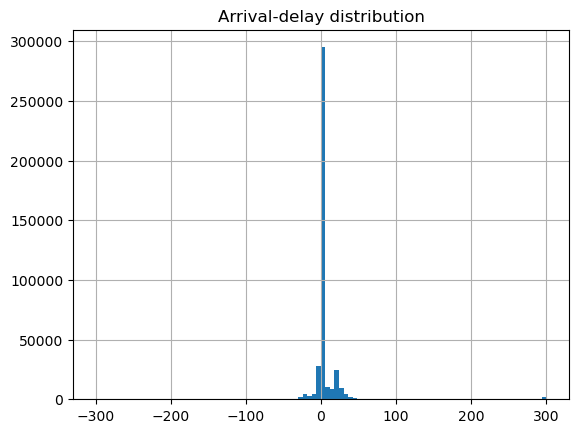

In [ ]:
# 1. How many zeros during revenue hours?
mask_service = feats_all["local_dt"].dt.hour.between(5, 23)
zero_hdw = feats_all[mask_service & (feats_all["headway_t"] == 0)]
print(len(zero_hdw), "zero headways between 05-23h")

# 2. TU latency behind those >10-min gaps
suspect = feats_all[feats_all["headway_t"] > 10 * 60]
print(suspect[["local_dt", "headway_t", "snapshot_timestamp"]].head())

# 3. Distribution of arrival_delay_t
feats_all["arrival_delay_t"].hist(bins=100)
plt.title("Arrival-delay distribution")

Text(0.5, 1.0, 'Headway distribution')

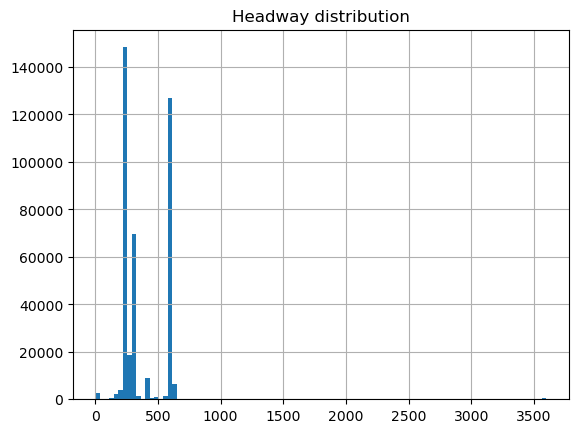

In [ ]:
# 4. Distribution of arrival_delay_t
feats_all["headway_t"].hist(bins=100)
plt.title("Headway distribution")

### Plots for one station

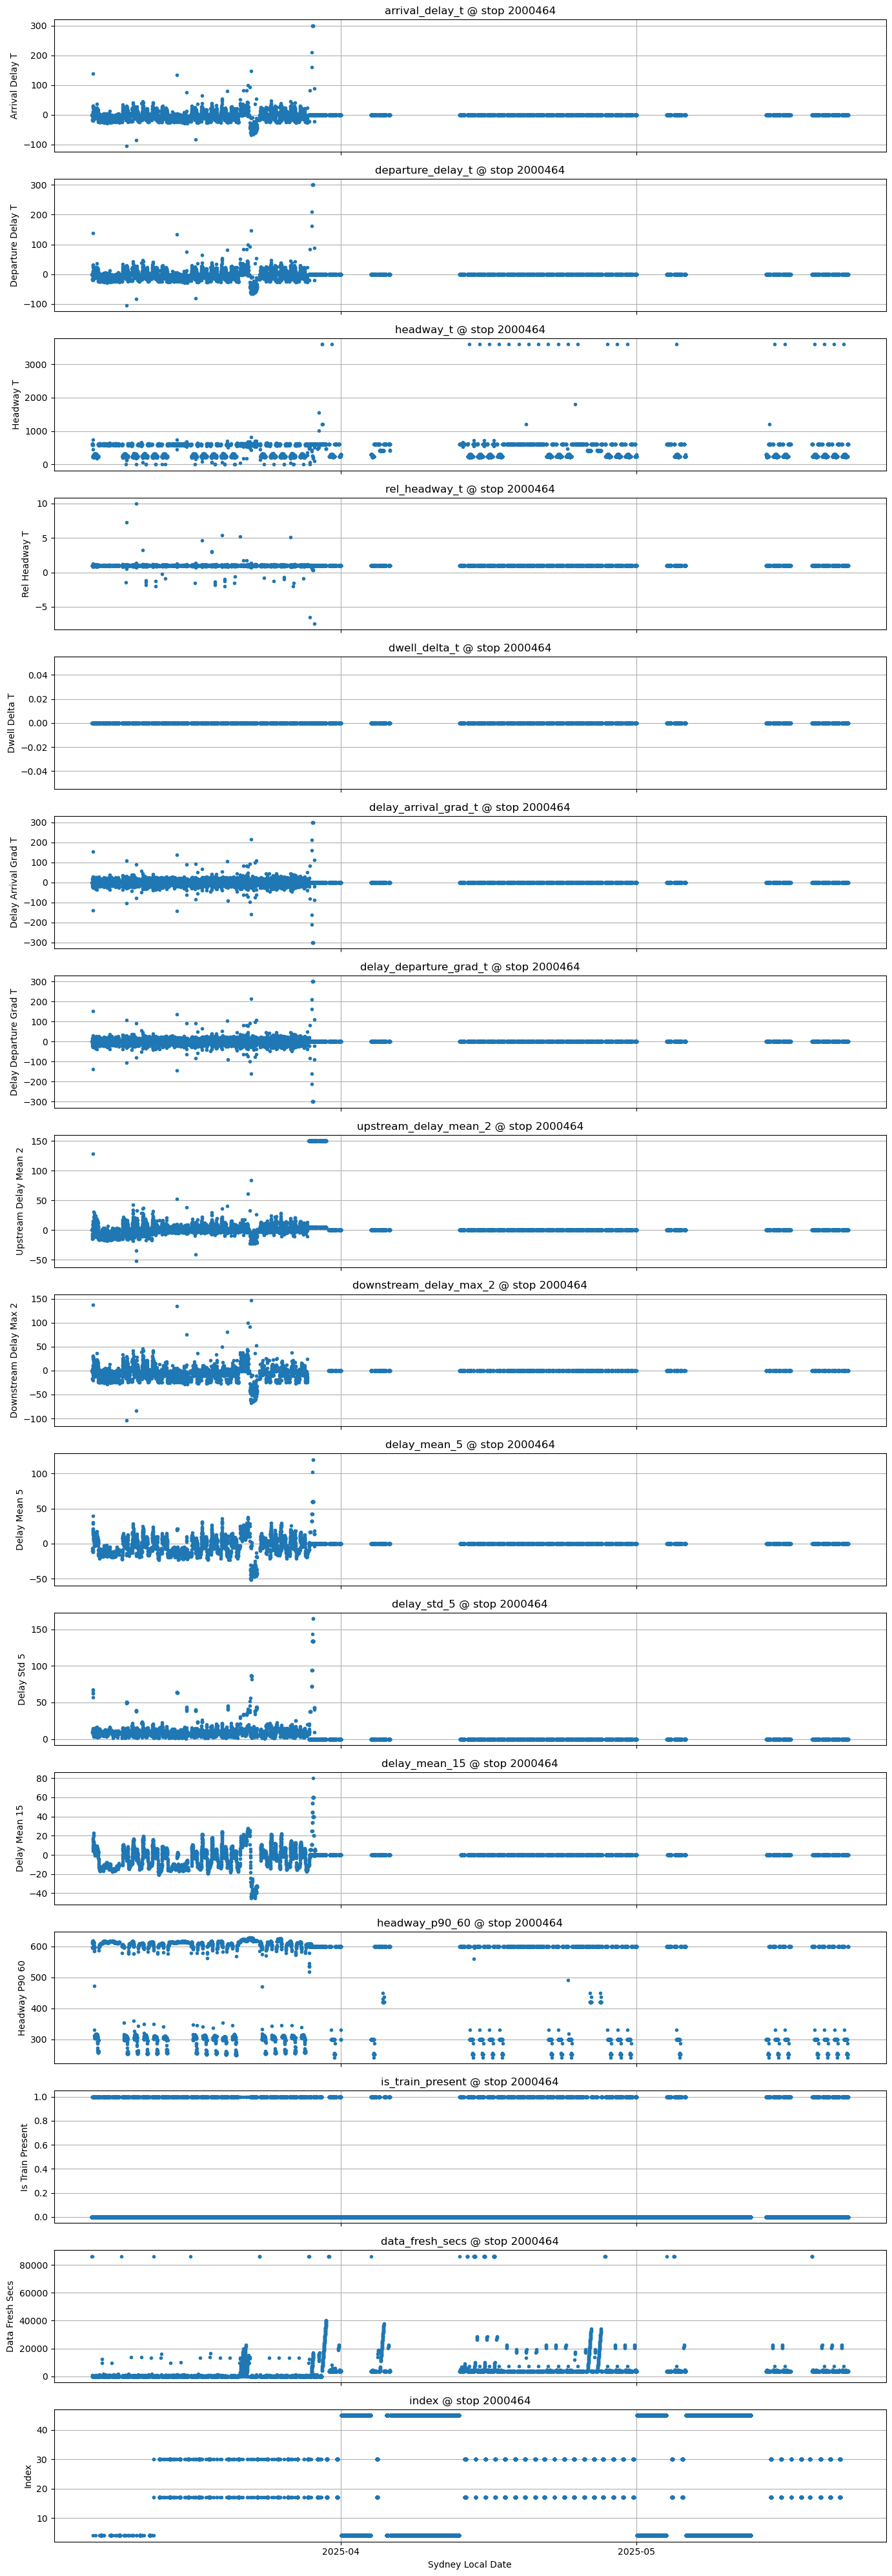

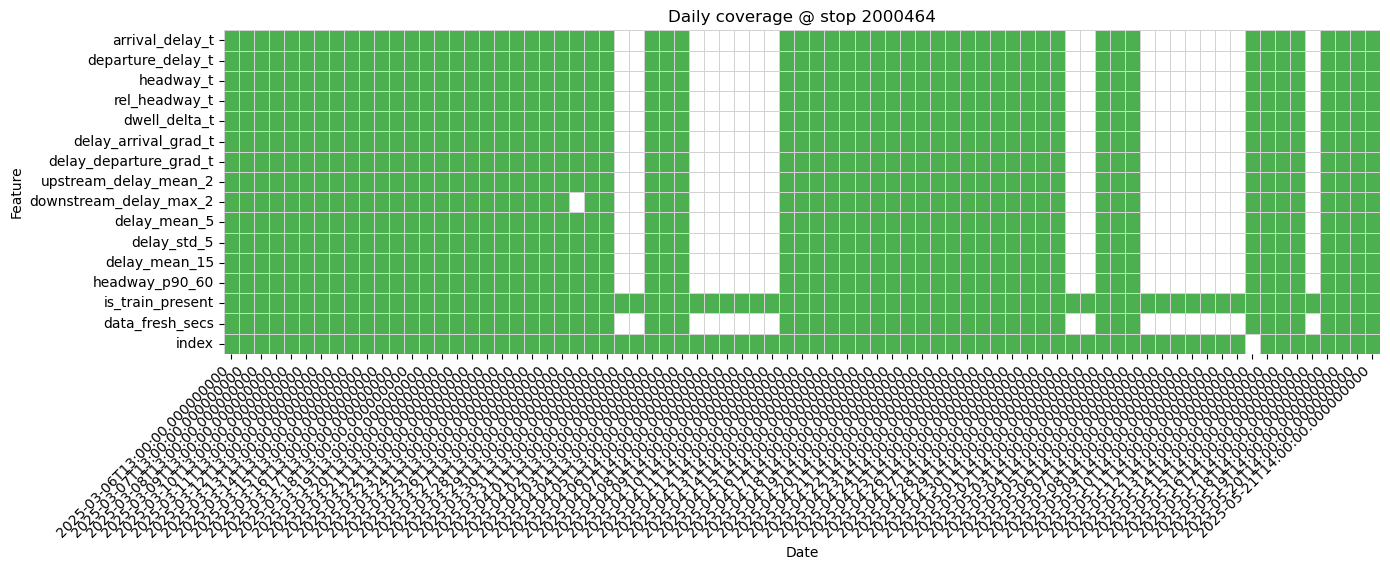

Days with *no* data: None 🎉


In [ ]:
import pytz
import seaborn as sns
from matplotlib.dates import DateFormatter, MonthLocator
from pandas.api.types import is_datetime64_any_dtype

station_id = 2000464

# 1) Subset on stop_id
sub = feats_all[feats_all["stop_id"].astype(int) == station_id].copy()
if sub.empty:
    raise ValueError(f"No rows found for stop_id {station_id}")

# 2) Ensure we have a tz-aware local_dt column
if "local_dt" not in sub.columns or not is_datetime64_any_dtype(sub["local_dt"]):
    tz_syd = pytz.timezone("Australia/Sydney")
    sub["local_dt"] = pd.to_datetime(sub["snapshot_timestamp"], unit="s", utc=True).dt.tz_convert(
        tz_syd
    )

# 3) Identify all the feature columns (everything except the meta-cols)
exclude = {
    "snapshot_timestamp",
    "stop_id",
    "direction_id",
    "route_id",
    "local_dt",
    "sin_hour",
    "cos_hour",
    "day_type",
    "node_degree",
    "hub_flag",
}
feat_cols = [c for c in sub.columns if c not in exclude]

# 4) Time-series panel: one subplot per feature
n = len(feat_cols)
fig, axes = plt.subplots(n, 1, figsize=(14, 2.5 * n), sharex=True)
if n == 1:
    axes = [axes]
month_loc = MonthLocator(interval=1)
fmt_month = DateFormatter("%Y-%m", tz=sub["local_dt"].dt.tz)

for ax, col in zip(axes, feat_cols):
    df = sub[["local_dt", col]].dropna()
    ax.plot(df["local_dt"], df[col], marker=".", linestyle="none")
    ax.set_ylabel(col.replace("_", " ").title())
    ax.xaxis.set_major_locator(month_loc)
    ax.xaxis.set_major_formatter(fmt_month)
    ax.grid(True)
    ax.set_title(f"{col} @ stop {station_id}")

axes[-1].set_xlabel("Sydney Local Date")
plt.tight_layout()
plt.show()

# 5) Daily coverage heat-map (1 if any non-NaN that day)
cov = (
    sub.set_index("local_dt")[feat_cols].resample("D").apply(lambda d: d.notna().any()).astype(int)
)

plt.figure(figsize=(14, max(2, n * 0.3 + 1)))
sns.heatmap(cov.T, cmap=["white", "#4caf50"], cbar=False, linewidths=0.5, linecolor="lightgray")
plt.title(f"Daily coverage @ stop {station_id}")
plt.ylabel("Feature")
plt.xlabel("Date")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 6) List totally empty days
empty = cov.index[cov.sum(axis=1) == 0]
print("Days with *no* data:", empty.date.tolist() if len(empty) else "None 🎉")

In [ ]:
# # 1) Choose the cutoff: everything on or after 2025-04-01 (Sydney time)
# cutoff = pd.Timestamp("2025-04-01", tz="Australia/Sydney")

# # 2) Subset your full features
# after = feats_all[feats_all["local_dt"] >= cutoff].copy()
# print(f"Rows ≥ {cutoff.date()}: {len(after)}\n")

# # 3) Define the key features you’re worried about
# check_features = [
#     "arrival_delay_t",
#     "departure_delay_t",
#     "rel_headway_t",
#     "dwell_delta_t",
#     "delay_arrival_grad_t",
#     "delay_departure_grad_t",
#     "upstream_delay_mean_2",
#     "downstream_delay_max_2",
#     "delay_mean_5",
#     "delay_std_5",
#     "delay_mean_15",
#     "headway_p90_60",
# ]

# # 4) For each, report total rows, non‐null count, zero count, and a small sample of uniques
# for feat in check_features:
#     total   = len(after)
#     nonnull = after[feat].notna().sum()
#     zeros   = (after[feat] == 0).sum()
#     uniques = after[feat].dropna().unique()[:5]
#     print(
#         f"{feat:25s} →  non-null: {nonnull:7d}   zeros: {zeros:7d}   "
#         f"NaN: {total - nonnull:7d}   sample uniques: {np.round(uniques,2)}"
#     )

# # 5) Also inspect overall distributions for a couple of them
# print("\nrel_headway_t stats:\n", after["rel_headway_t"].describe())
# print("\ndwell_delta_t stats:\n", after["dwell_delta_t"].describe())

# # 6) Check train‐present and data‐fresh
# print("\nis_train_present mean (should be >0):", after["is_train_present"].mean())
# print("data_fresh_secs non-null count:", after["data_fresh_secs"].notna().sum())


Rows ≥ 2025-04-01: 3411580

arrival_delay_t           →  non-null:  207267   zeros:  207267   NaN: 3204313   sample uniques: [0.]
departure_delay_t         →  non-null:  207267   zeros:  207267   NaN: 3204313   sample uniques: [0.]
rel_headway_t             →  non-null:  205117   zeros:       0   NaN: 3206463   sample uniques: [1.]
dwell_delta_t             →  non-null:  196465   zeros:  196465   NaN: 3215115   sample uniques: [0.]
delay_arrival_grad_t      →  non-null:  207267   zeros:  207267   NaN: 3204313   sample uniques: [0.]
delay_departure_grad_t    →  non-null:  207267   zeros:  207267   NaN: 3204313   sample uniques: [0.]
upstream_delay_mean_2     →  non-null:  207267   zeros:  207267   NaN: 3204313   sample uniques: [0.]
downstream_delay_max_2    →  non-null:  122282   zeros:  122282   NaN: 3289298   sample uniques: [0.]
delay_mean_5              →  non-null:  204978   zeros:  204978   NaN: 3206602   sample uniques: [0.]
delay_std_5               →  non-null:  204978   zeros

In [ ]:
# from datetime import datetime
# from pathlib import Path

# import pytz


# def compose_path(ts: int, root: Path, feed: str) -> Path:
#     """Return the Path for *feed* at snapshot *ts*.
#     Tries both YYYY-MM-DD and YYYY-DD-MM patterns and returns whichever file exists.
#     Raises if neither is found.
#     """
#     dt = datetime.fromtimestamp(ts, tz=pytz.UTC)
#     base = root / feed / f"year={dt.year:04d}" / f"month={dt.month:02d}" / f"day={dt.day:02d}"
#     fn_m = f"{feed}_{dt:%Y-%m-%d-%H-%M}.parquet"
#     fn_d = f"{feed}_{dt:%Y-%d-%m-%H-%M}.parquet"
#     p_m = base / fn_m
#     p_d = base / fn_d

#     if p_m.exists():
#         return p_m
#     if p_d.exists():
#         return p_d

#     raise FileNotFoundError(f"No {feed} file for ts={ts} (tried {p_m.name} and {p_d.name})")


# from datetime import datetime
# from pathlib import Path

# import pandas as pd
# import pytz

# # make sure this processed_rt is the *same* one you wrote your parquet into:
# processed_rt = project_root / "data" / "processed_final" / "rt"

# sample_ts = [
#     # pick an after-DST timestamp in Sydney local,
#     # then convert *that* to UTC seconds:
#     int(pd.Timestamp("2025-04-06 00:00:00", tz="Australia/Sydney").tz_convert("UTC").timestamp()),
#     int(pd.Timestamp("2025-05-06 12:00:00", tz="Australia/Sydney").tz_convert("UTC").timestamp()),
# ]

# for ts in sample_ts:
#     try:
#         p = compose_path(ts, processed_rt, "trip_updates")
#     except FileNotFoundError as e:
#         print(f"\n— ts={ts}: {e}")
#         continue

#     df = pd.read_parquet(p)
#     print("\nSnapshot UTC", datetime.fromtimestamp(ts, pytz.UTC))
#     print("Total TU rows:", len(df))
#     mask = df["stop_id"].astype(int) == 2000464
#     print("  at stop 2000464:", mask.sum())
#     delta = (df.loc[mask, "arrival_time"] - ts).dropna()
#     print("  arrival_time - ts stats:", delta.describe())


— ts=1743858000: No trip_updates file for ts=1743858000 (tried trip_updates_2025-04-05-13-00.parquet and trip_updates_2025-05-04-13-00.parquet)

— ts=1746496800: No trip_updates file for ts=1746496800 (tried trip_updates_2025-05-06-02-00.parquet and trip_updates_2025-06-05-02-00.parquet)


### Plots for all station

In [ ]:
import pytz
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.dates import DateFormatter, MonthLocator
from pandas.api.types import is_datetime64_any_dtype

# ─── configuration ──────────────────────────────────────────────────────────
OUT_PDF = "station_feature_plots.pdf"
PLOT_FEATURES = [
    "arrival_delay_t",
    "departure_delay_t",
    "headway_t",
    "rel_headway_t",
    "dwell_delta_t",
    "delay_arrival_grad_t",
    "delay_departure_grad_t",
    "upstream_delay_mean_2",
    "downstream_delay_max_2",
    "delay_mean_5",
    "delay_std_5",
    "delay_mean_15",
    "headway_p90_60",
    "is_train_present",
    "data_fresh_secs",
]
tz_syd = pytz.timezone("Australia/Sydney")

# ─── make sure local_dt exists globally (avoids repeating in loop) ──────────
if "local_dt" not in feats_all.columns or not is_datetime64_any_dtype(feats_all["local_dt"]):
    feats_all["local_dt"] = pd.to_datetime(
        feats_all["snapshot_timestamp"], unit="s", utc=True
    ).dt.tz_convert(tz_syd)

# ─── iterate over stations and export to a single PDF ───────────────────────
with PdfPages(OUT_PDF) as pdf:
    for sid in sorted(feats_all["stop_id"].astype(int).unique()):
        sub = feats_all[feats_all["stop_id"].astype(int) == sid].copy()
        if sub.empty:
            continue

        # choose only features that have at least one real value
        feat_cols = [c for c in PLOT_FEATURES if sub[c].notna().any()]
        n_feat = len(feat_cols)

        # ── 1. feature panel ────────────────────────────────────────────────
        fig, axes = plt.subplots(n_feat, 1, figsize=(16, 2.2 * n_feat), sharex=True)
        axes = np.ravel(axes)
        month_loc = MonthLocator(interval=1)
        fmt_month = DateFormatter("%Y-%m")

        for ax, col in zip(axes, feat_cols):
            sub[["local_dt", col]].dropna().plot(x="local_dt", y=col, ax=ax, legend=False)
            ax.set_title(col)
            ax.xaxis.set_major_locator(month_loc)
            ax.xaxis.set_major_formatter(fmt_month)
            ax.tick_params(axis="x", rotation=45)

        axes[-1].set_xlabel("Sydney local date")
        fig.suptitle(f"All features — stop {sid}", y=1.02, fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.98])

        # ── 2. daily coverage heat-map ──────────────────────────────────────
        coverage = (
            sub.set_index("local_dt")
            .groupby(pd.Grouper(freq="D"))[feat_cols]
            .apply(lambda d: d.notna().any())
            .astype(int)
        )
        fig2, ax2 = plt.subplots(figsize=(16, 5))
        sns.heatmap(
            coverage.T,
            cmap=["white", "#4caf50"],
            cbar=False,
            linewidths=0.5,
            linecolor="lightgrey",
            ax=ax2,
        )
        ax2.set_title(f"Daily feature coverage — stop {sid}")
        ax2.set_ylabel("feature")
        ax2.set_xlabel("date")
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
        ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)
        fig2.tight_layout()

        # — save both pages —
        pdf.savefig(fig)
        plt.close(fig)
        pdf.savefig(fig2)
        plt.close(fig2)

print(f"✅ Finished.  Plots saved to {OUT_PDF}")

✅ Finished.  Plots saved to station_feature_plots.pdf


In [ ]:
test_feat_parquet = pd.read_parquet(
    r"C:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\stations_features_time_series\year=2025\month=05\day=22\stations_feats_2025-22-05-01-01.parquet"
)

test_feat_parquet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype                           
---  ------                  --------------  -----                           
 0   stop_id                 59 non-null     object                          
 1   direction_id            59 non-null     int64                           
 2   arrival_delay_t         39 non-null     float64                         
 3   departure_delay_t       39 non-null     float64                         
 4   headway_t               17 non-null     float64                         
 5   rel_headway_t           17 non-null     float64                         
 6   dwell_delta_t           37 non-null     float64                         
 7   delay_arrival_grad_t    39 non-null     float64                         
 8   delay_departure_grad_t  39 non-null     float64                         
 9   upstream_delay_mean_2   39 non-nul

In [ ]:
print(test_feat_parquet['arrival_delay_t'])

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
44    0.0
45    0.0
46    0.0
47    0.0
48    0.0
49    0.0
50    0.0
51    0.0
52    0.0
53    0.0
54    0.0
55    0.0
56    0.0
57    0.0
58    0.0
Name: arrival_delay_t, dtype: float64


In [ ]:
# test_raw_parquet = pd.read_parquet(r"C:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\processed_final\rt\trip_updates\year=2025\month=05\day=22\trip_updates_2025-22-05-11-55.parquet")

# test_raw_parquet.info()

In [ ]:
# test_raw_parquet.head(10)

In [ ]:
# ts = 1747911300
# from metro_disruptions_intelligence.processed_reader import compose_path
# tu = compose_path(ts, processed_rt, "trip_updates")
# vp = compose_path(ts, processed_rt, "vehicle_positions")
# print("TU exists:", tu, tu.exists())
# print("VP exists:", vp, vp.exists())


In [ ]:
# how many trip_updates minutes _would_ be processed, vs how many actually get past that exists-check?
all_ts = discover_all_snapshot_minutes(processed_rt)
ok = [
    ts
    for ts in all_ts
    if compose_path(ts, processed_rt, "trip_updates").exists()
    and compose_path(ts, processed_rt, "vehicle_positions").exists()
]
print("raw trip_updates minutes:", len(all_ts))
print("minutes with both feeds present:", len(ok))

raw trip_updates minutes: 102428
minutes with both feeds present: 62281


In [ ]:
# pick one “key” column that must be non-null to count as “data exists”
key_cols = ["arrival_delay_t", "headway_t"]

# filter to any row where at least one of those cols is non-null
mask = feats_all[key_cols].notna().any(axis=1)
valid = feats_all.loc[mask]

# find the overall last timestamp
last = valid["local_dt"].max()
print("Last non-empty snapshot:", last)

# if you want it per stop:
last_per_stop = valid.groupby("stop_id")["local_dt"].max().sort_values()
print("Last non-empty per stop:")
print(last_per_stop)

Last non-empty snapshot: 2025-05-22 21:55:00+10:00
Last non-empty per stop:
stop_id
204472    2025-05-22 19:27:00+10:00
2155270   2025-05-22 20:11:00+10:00
2000461   2025-05-22 21:46:00+10:00
2154262   2025-05-22 21:46:00+10:00
2155266   2025-05-22 21:47:00+10:00
2154263   2025-05-22 21:47:00+10:00
2000460   2025-05-22 21:47:00+10:00
2113351   2025-05-22 21:48:00+10:00
2121226   2025-05-22 21:48:00+10:00
2067142   2025-05-22 21:48:00+10:00
2126159   2025-05-22 21:48:00+10:00
204471    2025-05-22 21:49:00+10:00
2060114   2025-05-22 21:49:00+10:00
2154265   2025-05-22 21:49:00+10:00
2000463   2025-05-22 21:49:00+10:00
2153404   2025-05-22 21:50:00+10:00
2113362   2025-05-22 21:50:00+10:00
2113341   2025-05-22 21:50:00+10:00
2153402   2025-05-22 21:50:00+10:00
2155265   2025-05-22 21:50:00+10:00
2155267   2025-05-22 21:50:00+10:00
2155268   2025-05-22 21:50:00+10:00
2000464   2025-05-22 21:51:00+10:00
2065164   2025-05-22 21:51:00+10:00
2065163   2025-05-22 21:52:00+10:00
2153405   2025-0

In [ ]:
# 1️⃣ Recompute the “last good” raw‐timestamp in UTC seconds
#    (we already have last_local = 2025-03-30 11:59:00+11:00)
last_local = pd.Timestamp("2025-03-30 11:59:00", tz="Australia/Sydney")
last_utc = last_local.tz_convert("UTC").timestamp()

# 2️⃣ Find all raw trip_update minutes
processed_rt = Path(
    r"C:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\processed_final\rt"
)


def discover_all_snapshot_minutes(root: Path) -> list[int]:
    minutes = []
    for f in (root / "trip_updates").rglob("trip_updates_*.parquet"):
        ts_part = f.stem.split("trip_updates_")[-1]
        try:
            # try both patterns
            dt = datetime.strptime(ts_part, "%Y-%m-%d-%H-%M")
        except ValueError:
            dt = datetime.strptime(ts_part, "%Y-%d-%m-%H-%M")
        minutes.append(int(pd.Timestamp(dt, tz="UTC").timestamp()))
    return sorted(set(minutes))


all_minutes = discover_all_snapshot_minutes(processed_rt)

# 3️⃣ Pick the next five after last_utc
next5 = [m for m in all_minutes if m > last_utc][:5]
print("Next five raw timestamps (UTC):", next5)
print("as UTC datetimes:", [datetime.fromtimestamp(m, pytz.UTC) for m in next5])


# 4️⃣ For each of those, compose the path, read the parquet, and inspect
def compose_path(ts: int, root: Path, feed: str) -> Path:
    dt = datetime.fromtimestamp(ts, tz=pytz.UTC)
    # two possible patterns
    fn_m = f"{feed}_{dt:%Y-%m-%d-%H-%M}.parquet"
    fn_d = f"{feed}_{dt:%Y-%d-%m-%H-%M}.parquet"
    base = root / feed / f"year={dt.year:04d}" / f"month={dt.month:02d}" / f"day={dt.day:02d}"
    p_m = base / fn_m
    p_d = base / fn_d
    return p_m if p_m.exists() else p_d


for ts in next5:
    path = compose_path(ts, processed_rt, "trip_updates")
    print("\n— Reading", path, "exists?", path.exists())
    df = pd.read_parquet(path)
    print(" rows:", len(df))
    print(
        " snapshot_timestamp min/max:",
        datetime.fromtimestamp(df["snapshot_timestamp"].min(), pytz.UTC),
        "→",
        datetime.fromtimestamp(df["snapshot_timestamp"].max(), pytz.UTC),
    )
    print(
        " arrival_delay nulls:",
        df["arrival_delay"].isna().sum(),
        "/",
        len(df),
        f"({100 * df['arrival_delay'].isna().mean():.1f}% missing)",
    )
    display(df.head(3))

Next five raw timestamps (UTC): [1743300000, 1743300060, 1743300120, 1743300180, 1743300240]
as UTC datetimes: [datetime.datetime(2025, 3, 30, 2, 0, tzinfo=<UTC>), datetime.datetime(2025, 3, 30, 2, 1, tzinfo=<UTC>), datetime.datetime(2025, 3, 30, 2, 2, tzinfo=<UTC>), datetime.datetime(2025, 3, 30, 2, 3, tzinfo=<UTC>), datetime.datetime(2025, 3, 30, 2, 4, tzinfo=<UTC>)]

— Reading C:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\processed_final\rt\trip_updates\year=2025\month=03\day=30\trip_updates_2025-30-03-02-00.parquet exists? True
 rows: 624
 snapshot_timestamp min/max: 2025-03-30 00:59:53+00:00 → 2025-03-30 00:59:53+00:00
 arrival_delay nulls: 0 / 624 (0.0% missing)


,snapshot_timestamp,trip_id,route_id,direction_id,start_time,start_date,vehicle_id,stop_sequence,stop_id,arrival_time,departure_time,arrival_delay,departure_delay,year,month,day
0,1743296393,0091-001-151-099:1000,SMNW_M1,0,12:49:09,20250330,Unassigned,1,2000467,NaN,1.743299e+09,0,0,2025,3,30
1,1743296393,0091-001-151-099:1000,SMNW_M1,0,12:49:09,20250330,Unassigned,2,2000464,1.743299e+09,1.743299e+09,0,0,2025,3,30
2,1743296393,0091-001-151-099:1000,SMNW_M1,0,12:49:09,20250330,Unassigned,3,2000463,1.743300e+09,NaN,0,0,2025,3,30



— Reading C:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\processed_final\rt\trip_updates\year=2025\month=03\day=30\trip_updates_2025-30-03-02-01.parquet exists? True
 rows: 612
 snapshot_timestamp min/max: 2025-03-30 01:00:53+00:00 → 2025-03-30 01:00:53+00:00
 arrival_delay nulls: 0 / 612 (0.0% missing)


,snapshot_timestamp,trip_id,route_id,direction_id,start_time,start_date,vehicle_id,stop_sequence,stop_id,arrival_time,departure_time,arrival_delay,departure_delay,year,month,day
0,1743296453,0091-001-151-099:1000,SMNW_M1,0,12:49:09,20250330,Unassigned,1,2000467,NaN,1.743299e+09,0,0,2025,3,30
1,1743296453,0091-001-151-099:1000,SMNW_M1,0,12:49:09,20250330,Unassigned,2,2000464,1.743299e+09,1.743299e+09,0,0,2025,3,30
2,1743296453,0091-001-151-099:1000,SMNW_M1,0,12:49:09,20250330,Unassigned,3,2000463,1.743300e+09,NaN,0,0,2025,3,30



— Reading C:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\processed_final\rt\trip_updates\year=2025\month=03\day=30\trip_updates_2025-30-03-02-02.parquet exists? True
 rows: 612
 snapshot_timestamp min/max: 2025-03-30 01:01:59+00:00 → 2025-03-30 01:01:59+00:00
 arrival_delay nulls: 0 / 612 (0.0% missing)


,snapshot_timestamp,trip_id,route_id,direction_id,start_time,start_date,vehicle_id,stop_sequence,stop_id,arrival_time,departure_time,arrival_delay,departure_delay,year,month,day
0,1743296519,0091-001-151-099:1000,SMNW_M1,0,12:49:09,20250330,Unassigned,1,2000467,NaN,1.743299e+09,0,0,2025,3,30
1,1743296519,0091-001-151-099:1000,SMNW_M1,0,12:49:09,20250330,Unassigned,2,2000464,1.743299e+09,1.743299e+09,0,0,2025,3,30
2,1743296519,0091-001-151-099:1000,SMNW_M1,0,12:49:09,20250330,Unassigned,3,2000463,1.743300e+09,NaN,0,0,2025,3,30



— Reading C:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\processed_final\rt\trip_updates\year=2025\month=03\day=30\trip_updates_2025-30-03-02-03.parquet exists? True
 rows: 609
 snapshot_timestamp min/max: 2025-03-30 01:02:53+00:00 → 2025-03-30 01:02:53+00:00
 arrival_delay nulls: 0 / 609 (0.0% missing)


,snapshot_timestamp,trip_id,route_id,direction_id,start_time,start_date,vehicle_id,stop_sequence,stop_id,arrival_time,departure_time,arrival_delay,departure_delay,year,month,day
0,1743296573,0091-001-151-099:1000,SMNW_M1,0,12:49:09,20250330,Unassigned,1,2000467,NaN,1.743299e+09,0,0,2025,3,30
1,1743296573,0091-001-151-099:1000,SMNW_M1,0,12:49:09,20250330,Unassigned,2,2000464,1.743299e+09,1.743299e+09,0,0,2025,3,30
2,1743296573,0091-001-151-099:1000,SMNW_M1,0,12:49:09,20250330,Unassigned,3,2000463,1.743300e+09,NaN,0,0,2025,3,30



— Reading C:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\processed_final\rt\trip_updates\year=2025\month=03\day=30\trip_updates_2025-30-03-02-04.parquet exists? True
 rows: 621
 snapshot_timestamp min/max: 2025-03-30 01:03:53+00:00 → 2025-03-30 01:03:53+00:00
 arrival_delay nulls: 0 / 621 (0.0% missing)


,snapshot_timestamp,trip_id,route_id,direction_id,start_time,start_date,vehicle_id,stop_sequence,stop_id,arrival_time,departure_time,arrival_delay,departure_delay,year,month,day
0,1743296633,0091-001-151-099:1000,SMNW_M1,0,12:49:09,20250330,Unassigned,1,2000467,NaN,1.743299e+09,0,0,2025,3,30
1,1743296633,0091-001-151-099:1000,SMNW_M1,0,12:49:09,20250330,Unassigned,2,2000464,1.743299e+09,1.743299e+09,0,0,2025,3,30
2,1743296633,0091-001-151-099:1000,SMNW_M1,0,12:49:09,20250330,Unassigned,3,2000463,1.743300e+09,NaN,0,0,2025,3,30


## Sydney Metro M Line
The `SMNW_M1` route-id corresponds to the Sydney Metro line currently running Tallawong ⇄ Chatswood.

In [ ]:
# import folium
# import pandas as pd

# gtfs_root = project_root / "sample_data" / "static"
# routes = pd.read_csv(gtfs_root / "routes.txt")
# stops = pd.read_csv(gtfs_root / "stops.txt")
# trips = pd.read_csv(gtfs_root / "trips.txt")
# stop_times = pd.read_csv(gtfs_root / "stop_times.txt")
# shapes = pd.read_csv(gtfs_root / "shapes.txt")

# m_route = routes[routes["route_id"] == "SMNW_M1"]
# display(m_route)
# m_trip = trips[trips["route_id"] == "SMNW_M1"].iloc[0]
# shape_points = shapes[shapes["shape_id"] == m_trip["shape_id"]].sort_values("shape_pt_sequence")
# line = list(zip(shape_points["shape_pt_lat"], shape_points["shape_pt_lon"]))
# stop_ids = stop_times[stop_times["trip_id"] == m_trip["trip_id"]]["stop_id"].unique()
# stops_subset = stops[stops["stop_id"].isin(stop_ids)]

# m = folium.Map(location=[-33.8, 151.1], zoom_start=11)
# folium.PolyLine(line, color="blue", weight=5, opacity=0.7).add_to(m)
# for _, row in stops_subset.iterrows():
#     folium.Marker([row.stop_lat, row.stop_lon], popup=f"{row.stop_name} ({row.stop_id})").add_to(m)
# m

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_color,route_text_color,route_url
0,SMNW_M1,SMNW,M1,Metro North West & Bankstown Line,Sydney Metro Network,401,168388,FFFFFF,NaN


## ■ VALIDATION

In [ ]:
# from pathlib import Path

# import pandas as pd

# from metro_disruptions_intelligence.features import SnapshotFeatureBuilder, build_route_map
# from metro_disruptions_intelligence.processed_reader import (
#     compose_path,
#     discover_all_snapshot_minutes,
# )
# from metro_disruptions_intelligence.utils_gtfsrt import sydney_time

# from pathlib import Path

# project_root = Path.cwd()
# if not (project_root / "sample_data").exists():
#     project_root = project_root.parent

# # Use sample_data or your real processed path
# root = project_root / "sample_data" / "rt_parquet"
# # root = project_root / "data" / "processed_final" / "rt"   # if using full dataset
# route_map = build_route_map(root)
# builder = SnapshotFeatureBuilder(route_map, log_every=None)


# minutes = discover_all_snapshot_minutes(root)


# def raw_vs_feat(ts):
#     tu = pd.read_parquet(compose_path(ts, root, "trip_updates"))
#     vp_path = compose_path(ts, root, "vehicle_positions")
#     vp = (
#         pd.read_parquet(vp_path)
#         if vp_path.exists()
#         else pd.DataFrame(columns=["snapshot_timestamp", "stop_id", "direction_id"])
#     )
#     print("---", sydney_time(ts), "---")
#     print("raw rows", len(tu))
#     print("arrival_delay!=0", (tu["arrival_delay"] != 0).sum())
#     print("departure_delay!=0", (tu["departure_delay"] != 0).sum())
#     hw = (
#         tu.sort_values(["stop_id", "direction_id", "arrival_time"])
#         .groupby(["stop_id", "direction_id"])["arrival_time"]
#         .diff()
#     )
#     print("headway intervals", hw.notna().sum())
#     feats = builder.build_snapshot_features(tu, vp, ts)
#     print("feats rows", len(feats))
#     for col in ["arrival_delay_t", "departure_delay_t", "rel_headway_t", "dwell_delta_t"]:
#         nz = (feats[col].fillna(0) != 0).sum()
#         nn = feats[col].notna().sum()
#         print(f"{col}: non-NaN={nn} non-zero={nz}")
#     return feats


# for ts in minutes[:3]:
#     raw_vs_feat(ts)

--- 2025-03-07 03:49:00+11:00 ---
raw rows 84
arrival_delay!=0 0
departure_delay!=0 0
headway intervals 60
feats rows 48
arrival_delay_t: non-NaN=20 non-zero=0
departure_delay_t: non-NaN=20 non-zero=0
rel_headway_t: non-NaN=0 non-zero=0
dwell_delta_t: non-NaN=19 non-zero=0
--- 2025-03-07 03:50:00+11:00 ---
raw rows 84
arrival_delay!=0 0
departure_delay!=0 0
headway intervals 60
feats rows 48
arrival_delay_t: non-NaN=0 non-zero=0
departure_delay_t: non-NaN=0 non-zero=0
rel_headway_t: non-NaN=0 non-zero=0
dwell_delta_t: non-NaN=0 non-zero=0
--- 2025-03-07 03:51:00+11:00 ---
raw rows 84
arrival_delay!=0 0
departure_delay!=0 0
headway intervals 60
feats rows 48
arrival_delay_t: non-NaN=0 non-zero=0
departure_delay_t: non-NaN=0 non-zero=0
rel_headway_t: non-NaN=0 non-zero=0
dwell_delta_t: non-NaN=0 non-zero=0


In [ ]:
# ts = minutes[0]
# tu = pd.read_parquet(compose_path(ts, root, "trip_updates"))
# tu = tu.sort_values(["stop_id", "direction_id", "arrival_time"])
# stop = tu["stop_id"].iloc[0]
# dirn = int(tu["direction_id"].iloc[0])
# subset = tu[(tu["stop_id"] == stop) & (tu["direction_id"] == dirn)].head(2)
# arr1, arr2 = subset["arrival_time"].to_list()
# delay1, delay2 = subset["arrival_delay"].to_list()
# dep2 = subset["departure_time"].iloc[1]
# headway = arr2 - arr1
# sched_hw = (arr2 - delay2) - (arr1 - delay1)
# rel_hw = headway / sched_hw if sched_hw else float("nan")
# dwell = dep2 - arr2
# sched_dwell = (dep2 - subset["departure_delay"].iloc[1]) - (arr2 - delay2)
# dwell_delta = dwell - sched_dwell
# print("Computed headway", headway, "sched_hw", sched_hw, "rel_hw", rel_hw)
# print("Computed dwell delta", dwell_delta)
# feats = builder.build_snapshot_features(
#     tu, pd.DataFrame(columns=["snapshot_timestamp", "stop_id", "direction_id"]), ts
# )
# print("Builder values:", feats.loc[(stop, dirn)][["headway_t", "rel_headway_t", "dwell_delta_t"]])

Computed headway 600.0 sched_hw 600.0 rel_hw 1.0
Computed dwell delta 0.0
Builder values: headway_t        NaN
rel_headway_t    NaN
dwell_delta_t    NaN
Name: (2000460, 1), dtype: object


Raw delays and builder features were checked for a handful of snapshots. Replace the counts above with a larger sample to verify if values drop to zero unexpectedly.

In [ ]:
# from pathlib import Path
# import pandas as pd
# import pytz
# from datetime import datetime
# from metro_disruptions_intelligence.processed_reader import (
#     discover_all_snapshot_minutes,
#     compose_path,
# )

# # ── point this at your RT folder ──────────────────────────
# root = project_root / "sample_data" / "rt_parquet"
# # root = project_root / "data" / "processed_final" / "rt"

# # ── find all snapshot‐minutes on disk ────────────────────────
# all_minutes = discover_all_snapshot_minutes(root)

# # ── keep only April & May 2025 ────────────────────────────────
# filtered = []
# for ts in all_minutes:
#     dt = datetime.fromtimestamp(ts, tz=pytz.UTC)
#     if dt.year == 2025 and dt.month in (4, 5):
#         filtered.append(ts)

# print(f"Checking {len(filtered):,} snapshots (April+May 2025) out of {len(all_minutes):,}")

# # ── now read only those ──────────────────────────────────────
# records = []
# for ts in filtered:
#     tu_path = compose_path(ts, root, "trip_updates")
#     if not tu_path.exists():
#         # skip missing files
#         continue
#     df = pd.read_parquet(tu_path)
#     records.append({
#         "ts": ts,
#         "rows": len(df),
#         "arrival_delay_nonnull": df["arrival_delay"].notna().sum(),
#         "arrival_delay_nonzero":   (df["arrival_delay"]   != 0).sum(),
#         "departure_delay_nonnull": df["departure_delay"].notna().sum(),
#         "departure_delay_nonzero": (df["departure_delay"] != 0).sum(),
#     })

# summary = pd.DataFrame(records)
# if summary.empty:
#     raise RuntimeError("No April/May trip_update Parquets found or all were missing!")

# # ── print overall totals ─────────────────────────────────────
# print("=== April+May raw-feed delay summary ===")
# print("Snapshots processed:", len(summary))
# print("Total rows:", summary["rows"].sum())
# print(
#     f"arrival_delay  non-null={summary['arrival_delay_nonnull'].sum():,}"
#     f"  non-zero={summary['arrival_delay_nonzero'].sum():,}"
# )
# print(
#     f"departure_delay non-null={summary['departure_delay_nonnull'].sum():,}"
#     f"  non-zero={summary['departure_delay_nonzero'].sum():,}"
# )

# # ── per-snapshot percent non-null stats ──────────────────────
# summary["arrival_delay_nonnull_pct"] = summary["arrival_delay_nonnull"] / summary["rows"]
# print("\narrival_delay non-null % per snapshot:")
# print(summary["arrival_delay_nonnull_pct"].describe().apply(lambda x: f"{x:.2%}"))


Checking 2,537 snapshots (April+May 2025) out of 2,968
=== April+May raw-feed delay summary ===
Snapshots processed: 2537
Total rows: 2222594
arrival_delay  non-null=2,222,594  non-zero=974,368
departure_delay non-null=2,222,594  non-zero=938,646

arrival_delay non-null % per snapshot:
count    253700.00%
mean        100.00%
std           0.00%
min         100.00%
25%         100.00%
50%         100.00%
75%         100.00%
max         100.00%
Name: arrival_delay_nonnull_pct, dtype: object


In [ ]:
# test_raw_parquet = pd.read_parquet(r"C:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\processed_final\rt\trip_updates\year=2025\month=05\day=22\trip_updates_2025-22-05-11-55.parquet")

# test_raw_parquet.info()

# test_raw_parquet.to_excel(r"trial.xlsx",index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   snapshot_timestamp  630 non-null    int64  
 1   trip_id             630 non-null    object 
 2   route_id            630 non-null    object 
 3   direction_id        630 non-null    int64  
 4   start_time          630 non-null    object 
 5   start_date          630 non-null    object 
 6   vehicle_id          630 non-null    object 
 7   stop_sequence       630 non-null    int64  
 8   stop_id             630 non-null    object 
 9   arrival_time        600 non-null    float64
 10  departure_time      600 non-null    float64
 11  arrival_delay       630 non-null    int64  
 12  departure_delay     630 non-null    int64  
 13  year                630 non-null    int64  
 14  month               630 non-null    int64  
 15  day                 630 non-null    int64  
dtypes: float

In [ ]:
# from pathlib import Path
# import pandas as pd
# from metro_disruptions_intelligence.features import SnapshotFeatureBuilder, build_route_map

# # 1) Point directly at the exact Parquet you were opening in Excel:
# tu_path = Path(r"C:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence"
#                r"\data\processed_final\rt\trip_updates"
#                r"\year=2025\month=05\day=22\trip_updates_2025-22-05-11-55.parquet")

# # 2) And its matching vehicle_positions (if you need it)
# vp_path = Path(r"C:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence"
#                r"\data\processed_final\rt\vehicle_positions"
#                r"\year=2025\month=05\day=22\vehicle_positions_2025-22-05-11-55.parquet")

# tu = pd.read_parquet(tu_path)
# vp = pd.read_parquet(vp_path) if vp_path.exists() else pd.DataFrame()

# # 3) Build your SnapshotFeatureBuilder exactly as before:
# root = Path(r"C:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence"
#             r"\data\processed_final\rt")
# route_map = build_route_map(root)
# builder   = SnapshotFeatureBuilder(route_map, log_every=None)

# # 4) Re‐run the same “future‐window + first()” logic by hand for stop 2000464:
# ts = 1747911300
# LAG, MAXF = builder.LAG_TU_SECS, builder.MAX_FUTURE_SECS
# tu_now    = tu[(tu.snapshot_timestamp <= ts) & (tu.snapshot_timestamp >= ts - LAG)]
# arr_diffs = tu_now.arrival_time - ts
# tu_future = tu_now[(tu_now.arrival_time >= ts) & (arr_diffs <= MAXF)].copy()

# # 5) Inspect the exact candidates at that stop:
# stop = "2000464"
# cands = tu_future[tu_future.stop_id == stop].sort_values("arrival_time")
# print(cands[["arrival_time","arrival_delay","departure_delay"]])

# # 6) See which one the builder actually chooses:
# print("\nBuilder picks →")
# print(cands.iloc[0][["arrival_time","arrival_delay","departure_delay"]])

# # 7) And compare to the builder’s output:
# feats = builder.build_snapshot_features(tu, vp, ts).reset_index()
# print("\nFeatureBuilder result →")
# print(feats.loc[(feats.stop_id == stop) & (feats.direction_id == 1),
#                 ["arrival_delay_t","departure_delay_t","headway_t"]])


     arrival_time  arrival_delay  departure_delay
185  1.747912e+09              7                7
353  1.747912e+09              4                4
17   1.747913e+09             13               13
584  1.747913e+09             21               21
416  1.747914e+09              2                2
458  1.747915e+09              0                0
332  1.747915e+09              0                0
59   1.747916e+09              0                0
248  1.747916e+09              0                0
605  1.747917e+09              0                0
626  1.747918e+09              0                0

Builder picks →
arrival_time       1747911610.0
arrival_delay                 7
departure_delay               7
Name: 185, dtype: object

FeatureBuilder result →
    arrival_delay_t  departure_delay_t  headway_t
23              7.0                7.0        NaN


In [ ]:

def validate_snapshot(ts):
    tu = pd.read_parquet(compose_path(ts, root, 'trip_updates'))
    vp_path = compose_path(ts, root, 'vehicle_positions')
    vp = pd.read_parquet(vp_path) if vp_path.exists() else pd.DataFrame(columns=['snapshot_timestamp','stop_id','direction_id'])
    raw_nz = (tu['arrival_delay'] != 0).sum()
    feats = builder.build_snapshot_features(tu, vp, ts)
    feat_nz = (feats['arrival_delay_t'].fillna(0) != 0).sum()
    status = 'PASS' if abs(raw_nz - feat_nz) <= 2 else 'FAIL'
    print(sydney_time(ts), status, raw_nz, feat_nz)
    return status

[validate_snapshot(ts) for ts in filtered[:3]]
